In [1]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [2]:
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl")
pickydeuterons = pd.read_csv("/Users/user/data/research/proton-deuteron/csv/pickydeuterons.csv")

In [4]:
picky = pd.merge(allclusters,
                 pickydeuterons,
                 on=['run', 'subrun', 'event'],
                 how='inner')

picky = picky.drop_duplicates(subset=['run', 'subrun', 'event']).reset_index(drop=True)

picky

,event_idx,run,subrun,event,file_path,event_index,particle_type,plane,cluster_idx,area,...,width,height,aspect_ratio,compactness,image_intensity,matrix_transformed,column_maxes,p,m,beamline_mass
0,2,8596,410,37727,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,52.0,...,37,2,18.500000,0.702703,"[[0.0, 17.0, 17.0, 18.0, 19.0, 19.0, 21.0, 19....","[[0.0, 16.0], [0.0, 17.0], [0.0, 17.0], [0.0, ...","[21.0, 32.0]",1,0,1822.06
1,33,9473,109,9096,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,10365.0,...,252,198,1.272727,0.207732,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, -0....","[27.0, 58.0, 61.0, 69.0, 67.0, 63.0, 78.0, 69....",1,0,1869.80
2,59,9783,28,4265,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,1719.0,...,217,36,6.027778,0.220046,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[17.0, -0.0, 0.0, 0.0, -0.0, -0.0, -0.0, -0.0...","[126.0, 98.0, 85.0, 103.0, 81.0, 78.0, 74.0, 8...",1,0,1826.83
3,99,8667,39,2811,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,27.0,...,27,1,27.000000,1.000000,"[[16.0, 19.0, 21.0, 23.0, 25.0, 28.0, 30.0, 31...","[[17.0], [19.0], [20.0], [22.0], [24.0], [26.0...",[36.0],1,1,2032.23
4,102,9481,248,19285,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,51.0,...,27,2,13.500000,0.944444,"[[17.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23...","[[16.0, 16.0], [16.0, 17.0], [17.0, 17.0], [18...","[25.0, 20.0]",1,0,2331.43
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,6901,9437,1,21,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,101.0,...,52,4,13.000000,0.485577,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 17.0, 0.0], [0.0, 0.0, 18.0, 0.0],...","[16.0, 24.0, 35.0, 38.0]",1,0,1865.10
352,6909,8658,41,3623,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,2395.0,...,190,34,5.588235,0.370743,"[[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[[17.0, -0.0, 0.0, -0.0, -0.0, -0.0, -0.0, -0....","[81.0, 162.0, 227.0, 262.0, 292.0, 289.0, 253....",1,0,1901.61
353,6911,8675,283,31646,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,108603.0,...,1881,237,7.936709,0.243615,"[[0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[[-0.0, 0.0, -0.0, -0.0, -0.0, -0.0, 0.0, -0.0...","[33.0, 29.0, 56.0, 149.0, 268.0, 210.0, 88.0, ...",1,0,1906.35
354,6954,8560,242,10465,/Users/user/data/research/proton-deuteron/rawd...,1,deuteron,collection,0,10002.0,...,351,193,1.818653,0.147646,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, 0.0, -0.0, -0.0, -0.0, 0.0, -0.0, -0.0...","[106.0, 93.0, 91.0, 131.0, 123.0, 106.0, 75.0,...",1,0,1942.51


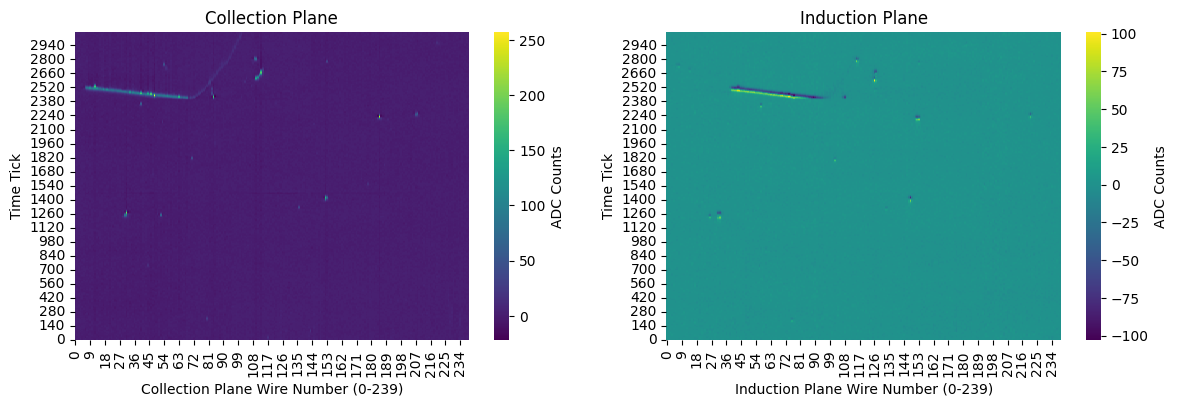

In [13]:
i = 290

event = Event(picky.iloc[i]['file_path'], index=picky.iloc[i]['event_index'])

Most are bad, not a good way to find clean deuteron data. 